# Preprocessing and cluster annotation

In [1]:
import os

import numpy as np
np.random.seed(42)
import pandas as pd

import scvelo as scv
import scanpy as sc

from scipy import sparse

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

%config Completer.use_jedi = False

In [2]:
DATA_PATH = "../data/"
OUTPUT_PATH = "../output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [3]:
# Import raw anndata
adata = sc.read(os.path.join(DATA_PATH, "tex_data_chronic.h5ad"))
adata

AnnData object with n_obs × n_vars = 13763 × 27998
    obs: 'sampleID', 'barcode', 'sample_type', 'timepoint'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

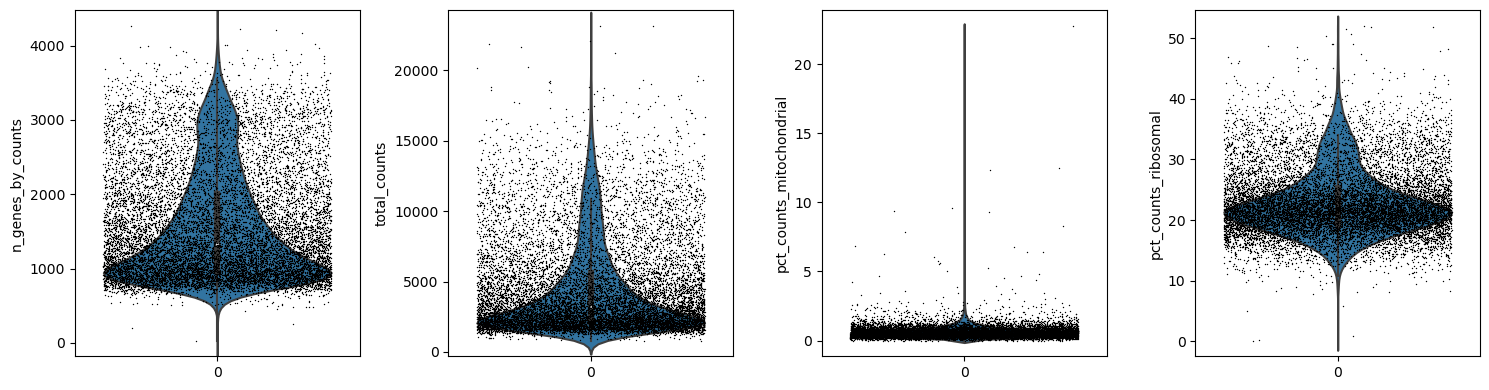

In [4]:
# Check QC measures
adata.var["mitochondrial"] = adata.var_names.str.startswith("mt-")
adata.var["ribosomal"] = adata.var_names.str.startswith(("Rps", "Rpl"))
qc_df = sc.pp.calculate_qc_metrics(adata, qc_vars=["mitochondrial","ribosomal"],
                                   percent_top=[20], log1p=True, inplace=True)

# Cell QC measures
fig, axs = plt.subplots(ncols=4, figsize=(15,4))

for i, qc_ in enumerate(["n_genes_by_counts", "total_counts", 
                      "pct_counts_mitochondrial",
                      "pct_counts_ribosomal",
                      ]):
    sns.violinplot(adata.obs[qc_], ax=axs.flat[i])
    sns.stripplot(adata.obs[qc_], jitter=0.4, s=1, 
                  color="black", ax=axs.flat[i])
plt.tight_layout()

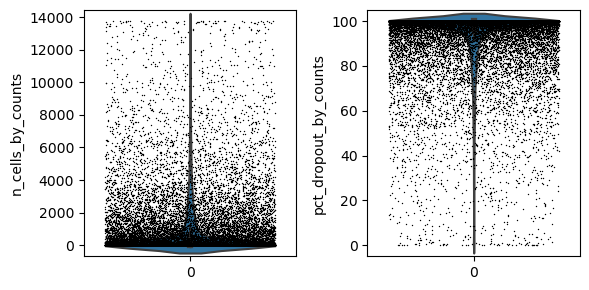

In [5]:
# Gene QC measures
fig, axs = plt.subplots(ncols=2, figsize=(6,3))

for i, qc_ in enumerate(["n_cells_by_counts", "pct_dropout_by_counts", 
                      ]):
    sns.violinplot(adata.var[qc_], ax=axs.flat[i])
    sns.stripplot(adata.var[qc_], jitter=0.4, s=1, 
                  color="black", ax=axs.flat[i])
    
plt.tight_layout()

In [6]:
# Filter based on QC
scv.pp.filter_genes(adata, min_shared_counts=20)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, max_genes=3500)
sc.pp.filter_cells(adata, max_counts=15000)

# Filter based on mitochondrial and ribosomal
adata = adata[adata.obs.pct_counts_mitochondrial <= 2]
adata = adata[adata.obs.pct_counts_ribosomal >= 10]
adata = adata[adata.obs.pct_counts_ribosomal <= 40]

adata

Filtered out 20743 genes that are detected 20 counts (shared).


View of AnnData object with n_obs × n_vars = 13410 × 7255
    obs: 'sampleID', 'barcode', 'sample_type', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mitochondrial', 'ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [7]:
# Cell cycle scoring
cell_cycle_genes = [x.strip().capitalize() for x in open(os.path.join(DATA_PATH, "regev_lab_cell_cycle_genes.txt"))]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

adata_ = sc.pp.normalize_total(adata, copy=True)
sc.pp.log1p(adata_)
sc.pp.scale(adata_)

sc.tl.score_genes_cell_cycle(adata_, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs["phase"] = adata_.obs.phase
adata.obs["S_score"] = adata_.obs.S_score
adata.obs["G2M_score"] = adata_.obs.G2M_score
adata.obs["score_diff"] = adata.obs.S_score - adata.obs.G2M_score

adata.var["cell_cycle_genes"] = False
adata.var.loc[[gene for gene in cell_cycle_genes if gene in adata.var_names], "cell_cycle_genes"] = True

In [8]:
# Preprocess the dataset
adata.layers["counts"] = adata.X.copy()

# scVelo selection
scv.pp.filter_and_normalize(adata, flavor="cell_ranger", log=True, n_top_genes=5000, subset_highly_variable=False)

# Remove mitochondrial and ribosomal genes
keep_genes = np.intersect1d(adata.var.index[~adata.var.mitochondrial], 
                           adata.var.index[~adata.var.ribosomal])
adata = adata[:, keep_genes]

# Remove cell cycle genes from HVGs
# adata.var.loc[adata.var.cell_cycle_genes, 'highly_variable'] = False

adata

Normalized count data: X, spliced, unspliced.
Extracted 5000 highly variable genes.
Logarithmized X.


View of AnnData object with n_obs × n_vars = 13410 × 7170
    obs: 'sampleID', 'barcode', 'sample_type', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes', 'n_counts', 'phase', 'S_score', 'G2M_score', 'score_diff'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mitochondrial', 'ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'cell_cycle_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts'

In [9]:
# Dimensionality reduction and clustering
adata.layers["log1p"] = adata.X.copy()
sc.pp.scale(adata)
adata.layers["scaled"] = adata.X.copy()
sc.pp.regress_out(adata, ["score_diff"])
sc.pp.scale(adata)

sc.pp.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata, use_rep="X_pca", n_neighbors=30)
sc.tl.leiden(adata)
sc.tl.umap(adata)
adata.obsm["X_umap"][:, 1] = -adata.obsm["X_umap"][:, 1]

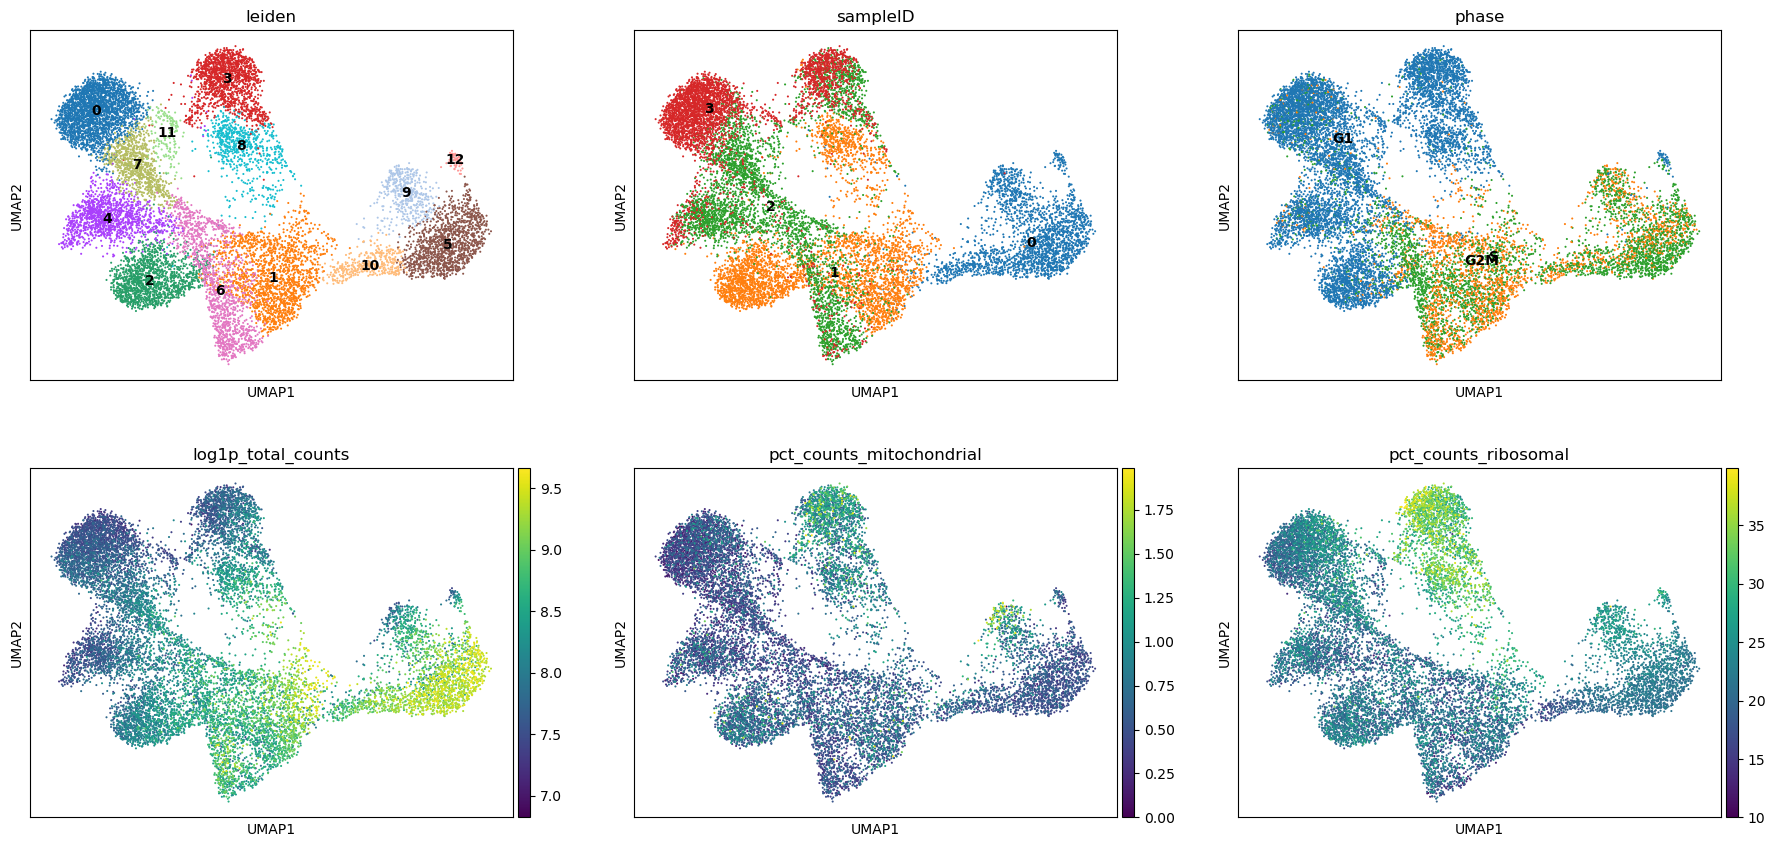

In [10]:
sc.pl.umap(adata, color=["leiden", "sampleID", "phase",
                         "log1p_total_counts", "pct_counts_mitochondrial", "pct_counts_ribosomal"],
           legend_loc="on data", ncols=3, cmap="viridis")

In [11]:
# Velocity analysis

# Smooth over k neighbors
scv.pp.moments(adata)

# Compute gene dynamics (optional)
scv.tl.recover_dynamics(adata, n_jobs=-1)

# Estimate velocity
scv.tl.velocity(adata, mode="stochastic")

# Post velocity analysis
scv.tl.velocity_graph(adata, mode_neighbors="connectivities", n_jobs=-1)
scv.tl.terminal_states(adata)
scv.tl.latent_time(adata)
scv.tl.velocity_confidence(adata)

# Transition probability matrix
adata.uns["T_forward"] = scv.utils.get_transition_matrix(adata, self_transitions=False)

# Visualize velocity
scv.tl.velocity_embedding(adata)

computing moments based on connectivities
    finished (0:00:08) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 52/52 cores)


/home/ubuntu/miniconda3/envs/cytopath/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1469 [00:00<?, ?gene/s]

    finished (0:38:31) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 52/52 cores)


/home/ubuntu/miniconda3/envs/cytopath/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/13410 [00:00<?, ?cells/s]

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    finished (0:00:50) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:07) --> added 
    'latent_time', shared time (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


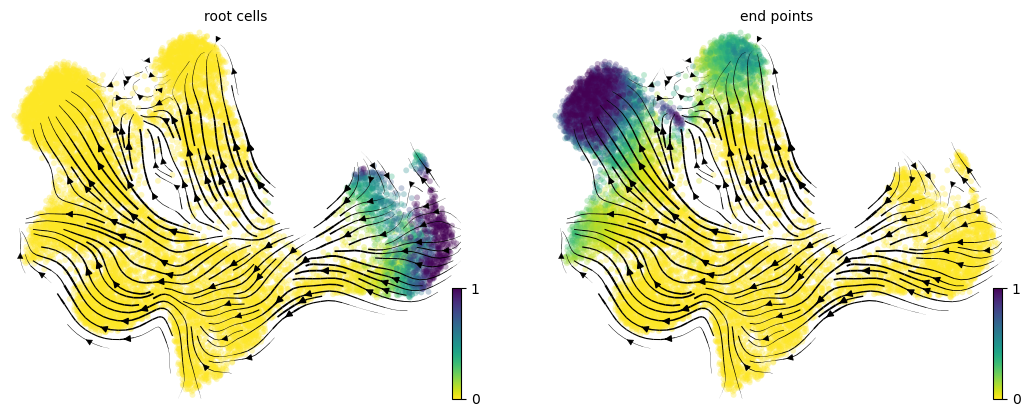

In [12]:
scv.pl.velocity_embedding_stream(adata, color=["root_cells", "end_points"])

In [13]:
# Differentially expressed genes per cluster
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

# Known marker genes of exhausted T cell subpopulations
marker_genes_dict = {"term_exh": ["Cxcr6", "Cd160", "Eomes", "Tox", "Lag3", "Entpd1"],
                     "mem_like": ["Il7r", "Tcf7", "Slamf6"],
                     "prolif": ["Mki67", "Cdca8"],
                     "exh": ["Gzmb", "Bcl2l11", "Anxa1", "Pdcd1"],
                     "eff_like": ["Cx3cr1", "Klre1", "Klra3", "Klrg1"],
                     "early": ["Icos", "Cdk2", "Sell"]}

marker_gene_overlap_tex = sc.tl.marker_gene_overlap(adata, marker_genes_dict, normalize="reference")

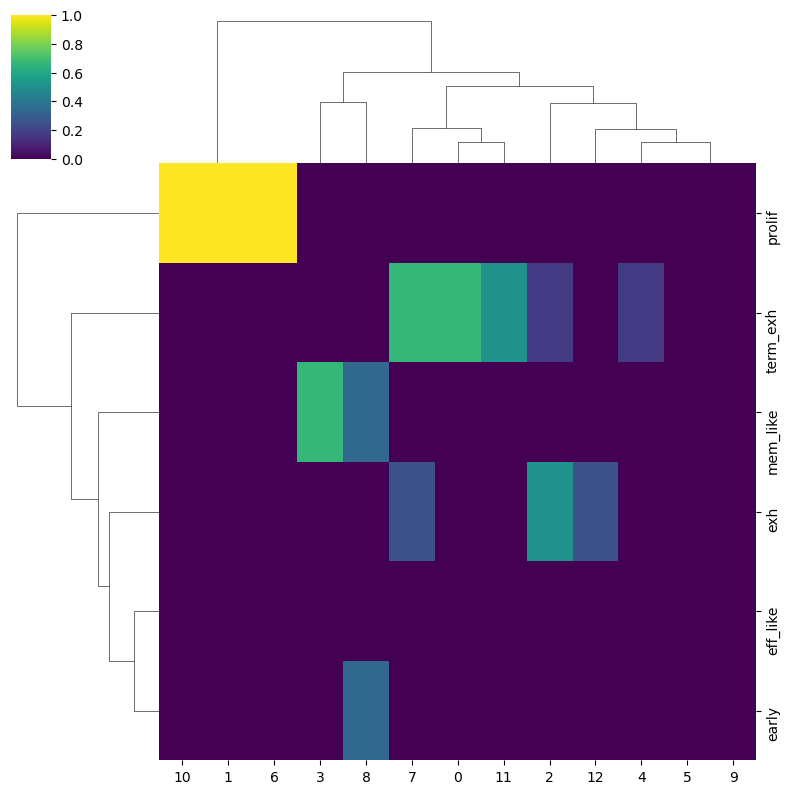

In [14]:
sns.clustermap(marker_gene_overlap_tex, cmap="viridis", figsize=(8, 8))

In [15]:
# Mean expression of marker genes per cluster
marker_genes = [m for l in marker_genes_dict.values() for m in l]
mean_exp = pd.DataFrame(columns=marker_genes, index=adata.obs.leiden.cat.categories, dtype=float)
for clust in adata.obs.leiden.cat.categories:
    mean_exp.loc[clust] = adata[adata.obs.leiden == clust, marker_genes].X.mean(axis=0)
mean_exp

,Cxcr6,Cd160,Eomes,Tox,Lag3,Entpd1,Il7r,Tcf7,Slamf6,Mki67,...,Bcl2l11,Anxa1,Pdcd1,Cx3cr1,Klre1,Klra3,Klrg1,Icos,Cdk2,Sell
0,0.810250,0.498296,0.222163,0.502566,0.394377,0.214342,-0.230046,-0.216432,-0.435920,-0.484975,...,0.044436,-0.220112,0.122871,-0.171074,-0.098617,-0.061183,-0.077461,-0.347531,-0.295202,-0.121453
1,-0.124660,-0.254079,-0.292475,-0.433629,-0.190616,-0.080584,-0.182154,-0.130939,0.002631,0.899993,...,-0.051840,0.412494,0.037097,-0.080150,-0.067523,-0.102250,0.043575,0.105406,0.390078,-0.019114
2,0.360013,-0.186214,-0.309344,-0.269019,0.244919,-0.034771,-0.056095,-0.192083,0.039243,-0.408498,...,0.540490,0.582934,0.063054,0.001645,-0.055460,-0.022841,0.066958,0.186774,-0.206471,-0.108985
3,-0.811363,-0.365731,0.252394,0.231599,0.098481,-0.159693,1.252220,0.880114,0.982143,-0.537578,...,-0.146720,-0.148176,-0.358797,-0.155662,-0.056882,-0.163790,-0.077021,0.383658,-0.326389,0.282988
4,0.222642,-0.584882,0.075908,0.237259,-0.005305,0.044967,-0.221381,-0.135692,-0.326310,-0.460786,...,-0.038246,-0.020829,-0.239807,0.918772,0.587968,0.463376,0.257408,-0.446949,-0.232310,-0.052304
5,-0.946464,-0.183409,-0.345492,-0.774371,-0.938711,-0.167599,-0.143869,-0.072369,-0.052476,0.580302,...,-0.361623,-0.170500,-0.089805,-0.146796,-0.109120,-0.155494,-0.071534,0.447200,0.534009,-0.113004
6,0.141107,0.386712,0.367730,0.320073,0.053520,0.076100,-0.253726,-0.202231,-0.353798,0.782101,...,-0.026503,-0.204353,0.187407,0.056117,0.036449,0.231720,0.013281,-0.457848,0.368890,-0.117592
7,0.989707,0.674779,0.206976,0.515751,0.704826,0.205397,-0.222639,-0.219298,-0.357432,-0.425848,...,0.137207,-0.192433,0.623533,-0.072909,0.007407,0.176927,-0.070403,-0.253219,-0.222258,-0.118880
8,-0.876861,0.233456,-0.033529,-0.029042,0.126965,-0.171773,0.409100,0.846921,1.345784,-0.417815,...,0.221488,-0.107644,0.002680,-0.176687,-0.128307,-0.162430,-0.081535,0.681466,-0.217791,0.909745
9,-0.971747,-0.183763,-0.393609,-0.769828,-1.006953,-0.170152,-0.112834,-0.029906,-0.053429,0.599235,...,-0.397628,-0.145918,-0.429912,-0.138644,-0.137881,-0.168310,-0.084607,0.448797,0.217612,-0.099832


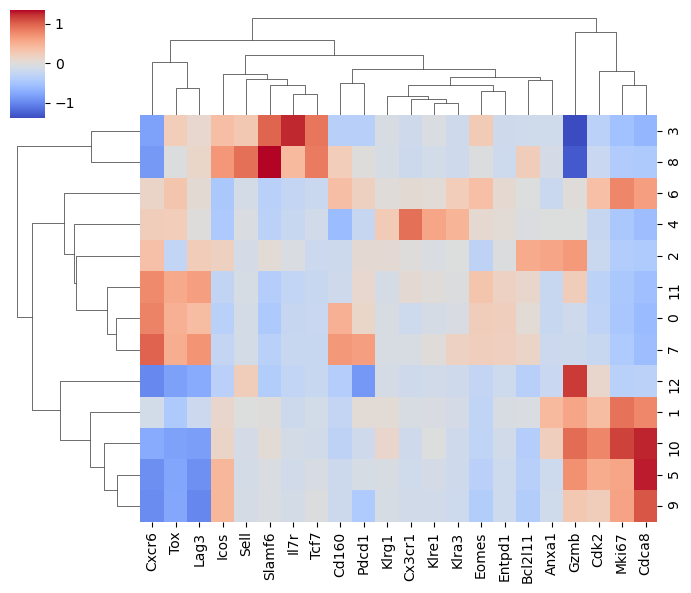

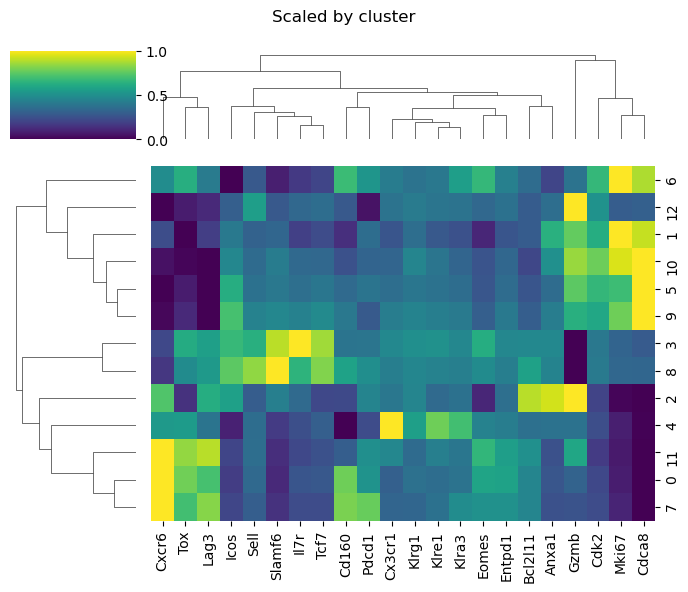

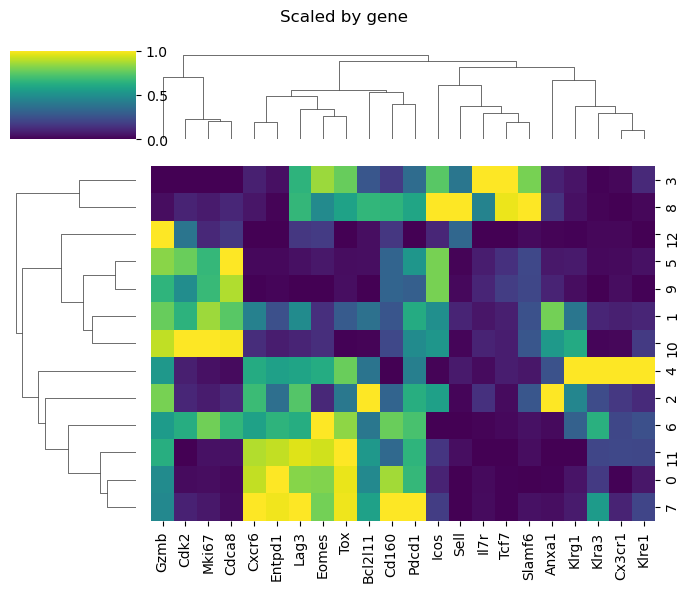

In [16]:
sns.clustermap(mean_exp, cmap="coolwarm", figsize=(7, 6))
sns.clustermap(mean_exp, cmap="viridis", figsize=(7, 6), standard_scale=0).fig.suptitle("Scaled by cluster")
plt.tight_layout()
sns.clustermap(mean_exp, cmap="viridis", figsize=(7, 6), standard_scale=1).fig.suptitle("Scaled by gene")
plt.tight_layout()

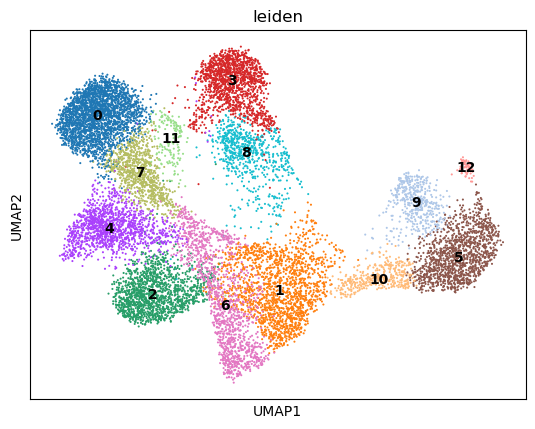

In [17]:
sc.pl.umap(adata, color="leiden", legend_loc="on data")

In [18]:
# Merge and annotate clusters based on mean marker expression
# no cc regression, cc genes not removed from HVGs, mt and ribo not removed
# adata.obs["annot"] = pd.Series(dtype=str)
# adata.obs.annot[adata.obs.leiden.isin(["2", "8"])] = "mem_like"  # Tcf7, Slamf6, Il7r
# adata.obs.annot[adata.obs.leiden == "4"] = "eff_like"  # Klra3, Klrg1, Cx3cr1, Klre1
# adata.obs.annot[adata.obs.leiden.isin(["0", "7", "9", "12"])] = "term_exh"  # Cxcr6, Entpd1, Lag3, Eomes, Tox
# adata.obs.annot[adata.obs.leiden.isin(["5"])] = "prolif"  # Mki67, Cdca3, Cdca8
# adata.obs.annot[adata.obs.leiden == "1"] = "int_exh"  # Anxa1, Bcl2l11, Gzmb
# adata.obs.annot[adata.obs.leiden.isin(["3", "6", "10", "11", "13"])] = "early"  # Icos, Cdk2
# adata.obs.annot = adata.obs.annot.astype("category")

# cc regression, cc genes not removed from HVGs
adata.obs["annot"] = pd.Series(dtype=str)
adata.obs.annot[adata.obs.leiden.isin(["3", "8"])] = "mem_like"  # Tcf7, Slamf6, Il7r
adata.obs.annot[adata.obs.leiden == "4"] = "eff_like"  # Klra3, Klrg1, Cx3cr1, Klre1
adata.obs.annot[adata.obs.leiden.isin(["0", "7", "11"])] = "term_exh"  # Cxcr6, Entpd1, Lag3, Eomes, Tox
adata.obs.annot[adata.obs.leiden.isin(["1", "6"])] = "prolif"  # Mki67, Cdca3, Cdca8
adata.obs.annot[adata.obs.leiden == "2"] = "int_exh"  # Anxa1, Bcl2l11, Gzmb
adata.obs.annot[adata.obs.leiden.isin(["5", "9", "10", "12"])] = "early"  # Icos, Cdk2
adata.obs.annot = adata.obs.annot.astype("category")

# no cc regression, cc genes removed from HVGs
# adata.obs["annot"] = pd.Series(dtype=str)
# adata.obs.annot[adata.obs.leiden.isin(["2", "9"])] = "mem_like"  # Tcf7, Slamf6, Il7r
# adata.obs.annot[adata.obs.leiden == "4"] = "eff_like"  # Klra3, Klrg1, Cx3cr1, Klre1
# adata.obs.annot[adata.obs.leiden.isin(["0", "7", "8", "12"])] = "term_exh"  # Cxcr6, Entpd1, Lag3, Eomes, Tox
# adata.obs.annot[adata.obs.leiden.isin(["5"])] = "prolif"  # Mki67, Cdca3, Cdca8
# adata.obs.annot[adata.obs.leiden == "1"] = "int_exh"  # Anxa1, Bcl2l11, Gzmb
# adata.obs.annot[adata.obs.leiden.isin(["3", "6", "10", "11", "13"])] = "early"  # Icos, Cdk2
# adata.obs.annot = adata.obs.annot.astype("category")
# 6 not completely clear

# no cc regression, cc genes retained
# adata.obs["annot"] = pd.Series(dtype=str)
# adata.obs.annot[adata.obs.leiden.isin(["2", "8"])] = "mem_like"  # Tcf7, Slamf6, Il7r
# adata.obs.annot[adata.obs.leiden == "4"] = "eff_like"  # Klra3, Klrg1, Cx3cr1, Klre1
# adata.obs.annot[adata.obs.leiden.isin(["0", "6", "9", "13"])] = "term_exh"  # Cxcr6, Entpd1, Lag3, Eomes, Tox
# adata.obs.annot[adata.obs.leiden.isin(["5", "12"])] = "prolif"  # Mki67, Cdca3, Cdca8
# adata.obs.annot[adata.obs.leiden == "1"] = "int_exh"  # Anxa1, Bcl2l11, Gzmb
# adata.obs.annot[adata.obs.leiden.isin(["3", "7", "10", "11", "14"])] = "early"  # Icos, Cdk2
# adata.obs.annot = adata.obs.annot.astype("category")
# 7 not completely clear

# cc regression, cc genes removed from HVGs
# adata.obs["annot"] = pd.Series(dtype=str)
# adata.obs.annot[adata.obs.leiden.isin(["3", "8"])] = "mem_like"  # Tcf7, Slamf6, Il7r
# adata.obs.annot[adata.obs.leiden == "4"] = "eff_like"  # Klra3, Klrg1, Cx3cr1, Klre1
# adata.obs.annot[adata.obs.leiden.isin(["0", "7", "11"])] = "term_exh"  # Cxcr6, Entpd1, Lag3, Eomes, Tox
# adata.obs.annot[adata.obs.leiden.isin(["1", "5"])] = "prolif"  # Mki67, Cdca3, Cdca8
# adata.obs.annot[adata.obs.leiden == "2"] = "int_exh"  # Anxa1, Bcl2l11, Gzmb
# adata.obs.annot[adata.obs.leiden.isin(["6", "9", "10", "12"])] = "early"  # Icos, Cdk2
# adata.obs.annot = adata.obs.annot.astype("category")

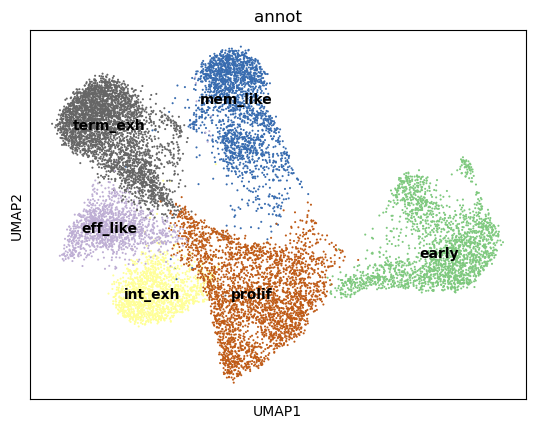

In [19]:
sc.pl.umap(adata, color="annot", legend_loc="on data", palette="Accent")

In [20]:
adata.write_h5ad(os.path.join(DATA_PATH, "tex_data_chronic_annotated.h5ad"))

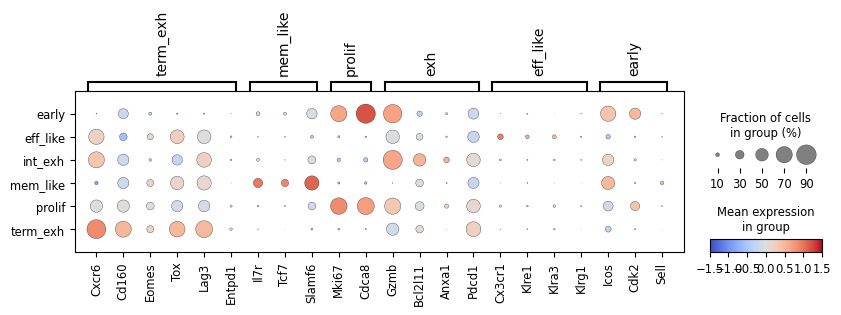

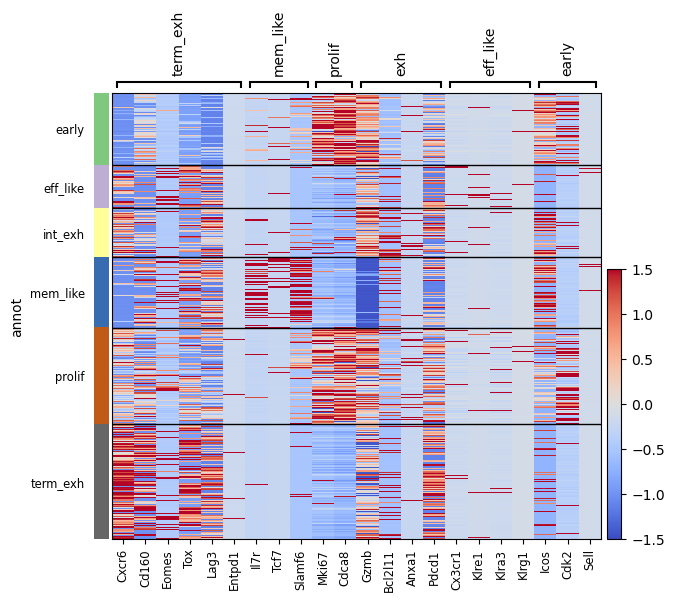

In [21]:
# Plot markers by annotated clusters
sc.pl.dotplot(adata, var_names=marker_genes_dict, groupby="annot", cmap="coolwarm", vmin=-1.5, vcenter=0, vmax=1.5)
sc.pl.heatmap(adata, var_names=marker_genes_dict, groupby="annot", cmap="coolwarm", vmin=-1.5, vcenter=0, vmax=1.5)